# Classification Systems

In this practical, you are asked to compare the prediction error of:

 1. The Naive Bayes Classifier
 2. LDA
 3. QDA
 4. Nearest Shrunken Centroids Classifier

On the Breast Cancer dataset provided in the previous notebooks, and the Prostate cancer dataset attached. The details about this last dataset are found in the reference:

Singh, D., Febbo, P., Ross, K., Jackson, D., Manola, J., Ladd, C., Tamayo, P., Renshaw, A., D’Amico, A., Richie, J., Lander, E., Loda, M., Kantoff, P., Golub, T., & Sellers, W. (2002). Gene expression correlates of clinical prostate cancer behavior. Cancer Cell, 1, 203–209.

This dataset is in CSV format and the last column contains the class label. The task of interest is to discriminate between normal and tumor tissue samples.

Importantly:

Use a random split of 2 / 3 of the data for training and 1 / 3 for testing each classifier. 
Any hyper-parameter of each method should be tuned using a grid-search guided by an inner cross-validation procedure that uses only training data.
To reduce the variance of the estimates, report average error results over 20 different partitions of the data into training and testing as described above.
Submit a notebook showing the code and the results obtained. Give some comments about the results and respond to these questions:

What method performs best on each dataset?
What method is more flexible?
What method is more robust to over-fitting?


In [68]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns; sns.set()
import scipy.stats as stats
import scipy as sp
from scipy import linalg
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

## Methods

In [81]:
def create_datasets_from_file(data_file, header, label_pos, label_value, features_ini, features_fin):
    """
    """
    data = pd.read_csv(data_file, header = header)
    X = data.values[ :, features_ini:features_fin].astype(np.float)
    y = (data.values[ :, label_pos ] == label_value).astype(np.int)
    # Split dataset between training and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1.0/3, random_state=1)
    print(X)
    # Data standardization
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Check standardization
    for i in range (1, np.size(x_train_scaled,1)):
        assert round(np.var(x_train_scaled[:,0]),3) == round(np.var(x_train_scaled[:,i]),3),\
        "Warning: revise data standardization"

    return x_train, x_test, y_train, y_test

def prediction_accuracy(x_train, x_test, y_train, y_test, method_func, method_param, param_value):
    """
    """
    if method_param != "" :
        params = {method_param : param_value}
    else:
        params ={}
    method = globals()[method_func](**params)
  
    # Training
    method.fit(x_train, y_train)

    # Prediction
    y_pred = method.predict(x_test)
    conf = confusion_matrix(y_test, y_pred)
    TN = conf[0][0]
    TP = conf[1][1]
    FP = conf[0][1]
    FN = conf[1][0]
    print(conf)
    print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
    print('True postive rate is: %f' % (TP / (TP + FN)))
    print('True negative rate is: %f\n' % (TN / (TN + FP)))

def estimate_parameter(x_train, x_test, y_train, y_test, method_func, param, param_values):
    """
    """
    # Pipeline for estimate the regularization parameter
    pipeline = Pipeline([ ('method', globals()[method_func]()) ])

    # Construct the grid the hyperparameter candidate shronk theshold
    param_grid = { 'method__' + param : param_values }

    # Evaluating 
    skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid, \
        scoring=make_scorer(accuracy_score))
    result = gridcv.fit(x_train, y_train)

    # Accuracies
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']

    test_accuracies = np.ones(len(param_values))

    for i in range(len(param_values)):
        method_params = {param : param_values[ i ]}
        method = globals()[method_func](**method_params)
        method.fit(X_train_scaled, y_train)
        test_accuracies[ i ] = accuracy_score(method.predict(x_test), y_test)

    # Plot
    plt.figure(figsize=(15, 10))
    line1, = plt.plot(param_values, accuracies, 'o-', color="g")
    line2, = plt.plot(param_values, test_accuracies, 'x-', color="r")
    plt.fill_between(param_values, accuracies - std_accuracies / np.sqrt(10), \
        accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
    plt.grid()
    plt.title("Different regularization parameter values for " + method_func)
    plt.xlabel('Regularization Parameter')
    plt.xticks(np.round(np.array(param_values), 2))
    plt.ylabel('Classification Accuracy')
    plt.ylim((0.9, 1.0))

    plt.xlim((min(param_values), max(param_values)))
    legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                              markersize=15, label='CV-estimate'), \
                    mlines.Line2D([], [], color='r', marker='x', \
                              markersize=15, label='Test set estimate')]
    plt.legend(handles=legend_handles, loc = 3)
    plt.show()

In [82]:
X_train, X_test, y_train, y_test = create_datasets_from_file('./data/wdbc.csv', None, 1, "B", 2, -1)

#X_train, X_test, y_train, y_test = create_datasets_from_file('./data/prostate.csv', 0, -1, 1, 0, -1)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]


In [83]:
print(X_test)

[[1.469e+01 1.398e+01 9.822e+01 ... 1.108e-01 2.827e-01 9.208e-02]
 [1.317e+01 1.866e+01 8.598e+01 ... 2.088e-01 3.900e-01 1.179e-01]
 [1.295e+01 1.602e+01 8.314e+01 ... 1.056e-01 3.380e-01 9.584e-02]
 ...
 [1.330e+01 2.157e+01 8.524e+01 ... 5.614e-02 2.637e-01 6.658e-02]
 [1.866e+01 1.712e+01 1.214e+02 ... 1.674e-01 2.894e-01 8.456e-02]
 [1.249e+01 1.685e+01 7.919e+01 ... 2.784e-02 1.917e-01 6.174e-02]]


In [84]:
print(X_train_scaled.shape)
# Naive Bayes
prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "GaussianNB", "", "")

(379, 30)
[[ 61   5]
 [  7 117]]
Predicion accuracy is: 0.936842
True postive rate is: 0.943548
True negative rate is: 0.924242



In [71]:
# LDA accuracy
prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "LinearDiscriminantAnalysis", "", "")

ValueError: Found input variables with inconsistent numbers of samples: [379, 68]

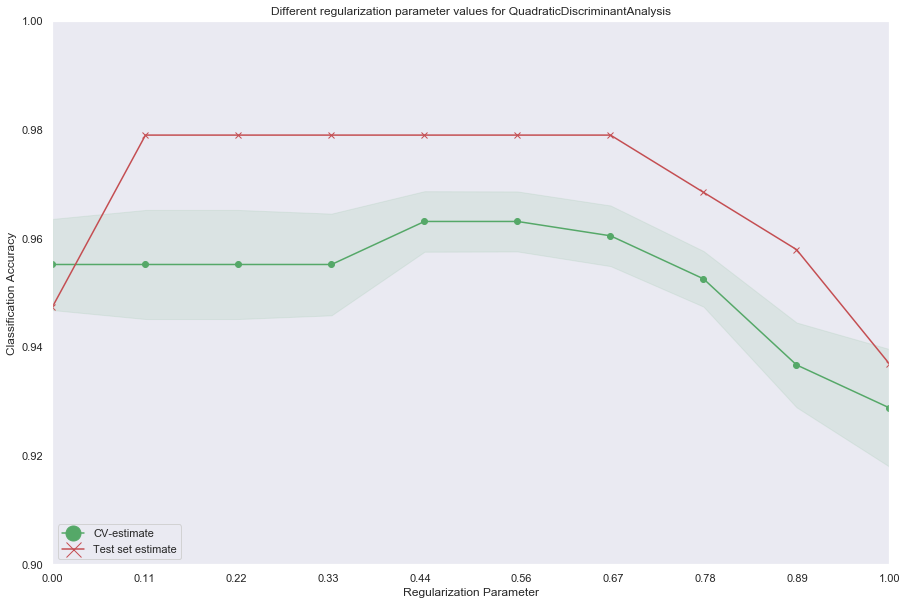

In [17]:
# QDA estimate reg parameter
param_values = np.linspace(0, 1, 10).tolist()
estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                   "QuadraticDiscriminantAnalysis", "reg_param", param_values)

In [8]:
# QDA accuracy
# Best parameter value according CV estimate
best_reg_param_value = 0.444
prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "QuadraticDiscriminantAnalysis", "reg_param", best_reg_param_value)

[[ 62   4]
 [  0 124]]
Predicion accuracy is: 0.978947
True postive rate is: 1.000000
True negative rate is: 0.939394



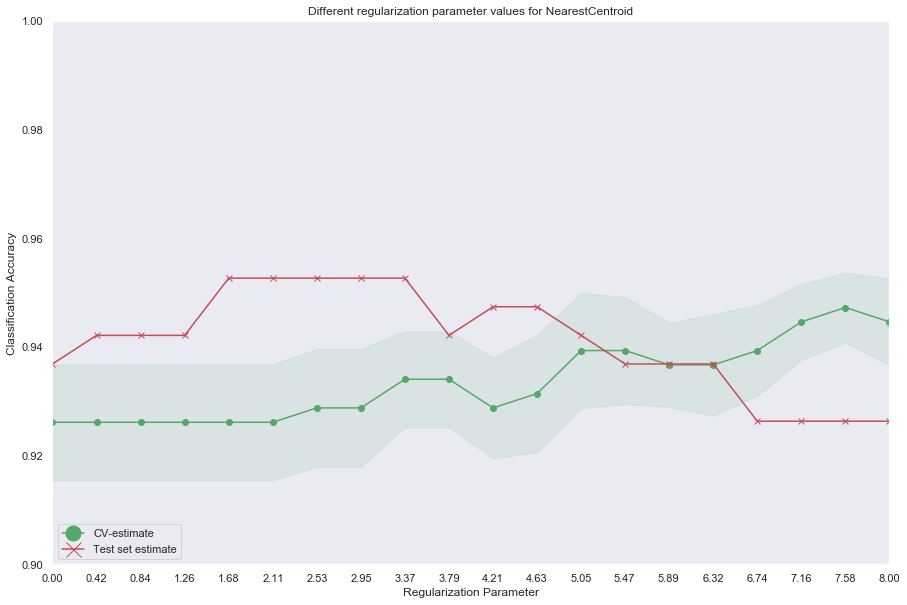

In [18]:
# Centroids
param_values = np.linspace(0, 8, 20).tolist()
estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                   "NearestCentroid", "shrink_threshold", param_values)

In [19]:
# Centroids accuracy
prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "NearestCentroid", "shrink_threshold", 3.4)

[[ 60   6]
 [  3 121]]
Predicion accuracy is: 0.952632
True postive rate is: 0.975806
True negative rate is: 0.909091



# Outputs

In [34]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx classification_systems.ipynb 1> /dev/null
pdflatex -shell-escape classification_systems 1> /dev/null
jupyter nbconvert --to html_with_toclenvs classification_systems.ipynb 1> /dev/null

[NbConvertApp] Converting notebook classification_systems.ipynb to latex
[NbConvertApp] Writing 29868 bytes to classification_systems.tex
[NbConvertApp] Converting notebook classification_systems.ipynb to html_with_toclenvs
[NbConvertApp] Writing 293429 bytes to classification_systems.html
